In [1]:
# global config

import os
import sys

parentdir = os.path.dirname(os.getcwd())
sys.path.insert(0, parentdir)

to_dir = '../data/german/'
if not os.path.exists(to_dir):
    os.makedirs(to_dir)

In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import gc
import joblib
from utils.func import timer
from eda.desc_stats import show_desc
from eda.feature_select import feature_select
from eda.data_preprocess import capping
from model.auto_model_classify import AutoMachineLearning

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

from utils.func import setRandomSeed
setRandomSeed(2022)

%load_ext autoreload
%autoreload 2

In [3]:
# load data from hive

base_data = pd.read_csv(to_dir+'german.csv', delim_whitespace = True, header = None)
base_data.columns = ['status_account','duration','credit_history','purpose', 'amount',
            'svaing_account', 'present_emp', 'income_rate', 'personal_status',
            'other_debtors', 'residence_info', 'property', 'age',
            'inst_plans', 'housing', 'num_credits',
            'job', 'dependents', 'telephone', 'foreign_worker', 'target']
base_data.target = base_data.target - 1
show_desc(base_data, detail=False)
print(base_data['target'].value_counts()/base_data['target'].value_counts().sum())
base_data.head()

原始数据集： (1000, 21)
重复行数： 0
去重后数据集： (1000, 21)
包含空值的字段个数： 0
数据类型分布： {dtype('int64'): 8, dtype('O'): 13}
0    0.7
1    0.3
Name: target, dtype: float64


,status_account,duration,credit_history,purpose,amount,svaing_account,present_emp,income_rate,personal_status,other_debtors,...,property,age,inst_plans,housing,num_credits,job,dependents,telephone,foreign_worker,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,1


In [4]:
THE_EMPTY_FLAG = [np.nan, 'null', 'NULL', -999, '-999', 9999, -9998]
TO_EMPTY_STATUS = np.nan
base_data.replace(THE_EMPTY_FLAG, TO_EMPTY_STATUS, inplace=True) # preprocess1: 统一缺失值标识

# base_data.drop(['id'], axis=1, inplace=True)  # preprocess: 删除冗余字段
# show_desc(base_data, detail=False)
base_data = base_data.drop_duplicates().reset_index(drop=True) # preprocess2: 特征+标签去重，不包括ID。
print(base_data.shape)

# base_data[total_feats] = base_data[total_feats].apply(capping) # preprocess: 异常值处理

print(base_data['target'].value_counts()/base_data['target'].value_counts().sum())
desc_df = show_desc(base_data, detail=True)
# desc_df.to_excel(to_dir+'desc_df.xlsx')

(1000, 21)
0    0.7
1    0.3
Name: target, dtype: float64
原始数据集： (1000, 21)
重复行数： 0
去重后数据集： (1000, 21)
包含空值的字段个数： 0
数据类型分布： {dtype('int64'): 8, dtype('O'): 13}


In [5]:
total_feats = base_data.columns.to_list()
total_feats.remove('target')
ordered_category = base_data.select_dtypes('object').columns.to_list() # 有序类别特征
unordered_category = [] # 无序类别特征
print(total_feats)
print(ordered_category)

['status_account', 'duration', 'credit_history', 'purpose', 'amount', 'svaing_account', 'present_emp', 'income_rate', 'personal_status', 'other_debtors', 'residence_info', 'property', 'age', 'inst_plans', 'housing', 'num_credits', 'job', 'dependents', 'telephone', 'foreign_worker']
['status_account', 'credit_history', 'purpose', 'svaing_account', 'present_emp', 'personal_status', 'other_debtors', 'property', 'inst_plans', 'housing', 'job', 'telephone', 'foreign_worker']


In [6]:
from sklearn.preprocessing import OrdinalEncoder

status_account = ['A11', 'A12', 'A13', 'A14']
credit_history = ['A30', 'A31', 'A32', 'A33', 'A34']
purpose = ['A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A48', 'A49', 'A410']
svaing_account = ['A61', 'A62', 'A63', 'A64', 'A65']
present_emp = ['A71', 'A72', 'A73', 'A74', 'A75']
personal_status = ['A91', 'A92', 'A93', 'A94']
other_debtors = ['A101', 'A102', 'A103']
property = ['A121', 'A122', 'A123', 'A124']
inst_plans = ['A141', 'A142', 'A143']
housing = ['A151', 'A152', 'A153']
job = ['A171', 'A172', 'A173', 'A174']
telephone = ['A191', 'A192']
foreign_worker = ['A201', 'A202']
categories=[status_account,credit_history,purpose,svaing_account,present_emp,personal_status,other_debtors,property,inst_plans,housing,job,telephone,foreign_worker]

enc = OrdinalEncoder(categories=categories) 
enc.fit(base_data[ordered_category])

base_data[ordered_category] = enc.transform(base_data[ordered_category])

In [7]:
feat_selector = feature_select(base_data, total_feats, 'target', bins=20)
feat_selector._filter_by_desc(missing=0.9, freq=0.99)
feat_selector.bins_and_iv(cont_bin='tree', dist_bin='value')
feat_selector._filter_by_bins_iv(iv_filter=0.01)
feat_selector._filter_by_corr()
feat_selector._filter_by_psi()
feat_selector._filter_by_vif()

选择缺失值占比小于0.9且最大单一值占比小于0.99的特征：20个。剔除变量0个。
选择分箱后IV大于等于0.01的特征：14个。剔除变量6个。
选择相关系数小于等于0.8的特征：14个。剔除变量0个。
选择PSI小于等于0.1的特征：14个。剔除变量0个。
选择VIF小于等于10的特征：14个。剔除变量0个。


In [8]:
from utils.rule_set import generate_single_rules,generate_multi_rules
generate_single_rules(feat_selector.bin_iv_woe_df.copy(), lift=1.8)

,index,feature,bin,bin_low,bin_up,total,bad,good,bad_rate,cum_total,cum_bad,lift,bad%,good%,woe,iv
13,0,credit_history,"(-inf, 1.5]",-inf,1.5,60,35,25,0.583333,60,35,1.991870,0.170732,0.050505,-1.218020,0.146438
14,1,credit_history,"(1.5, 2.5]",1.5,2.5,380,115,265,0.302632,440,150,1.164080,0.560976,0.535354,-0.046750,0.001198
15,2,credit_history,"(2.5, 3.5]",2.5,3.5,64,22,42,0.343750,504,172,1.165312,0.107317,0.084848,-0.234921,0.005278
16,3,credit_history,"(3.5, inf]",3.5,inf,196,33,163,0.168367,700,205,1.000000,0.160976,0.329293,0.715695,0.120464


In [14]:
# 基于较高lift或bad_rate的U型变量，所构造的决策树
cand_models = [DecisionTreeClassifier]
auto_model = AutoMachineLearning(base_data, feat_selector.feats, 'target', cand_models)
tree_model = auto_model.main_search()

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END class_weight=balanced, max_depth=2, min_samples_leaf=0.05; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, min_samples_leaf=0.05; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, min_samples_leaf=0.05; total time=   0.0s
[CV] END class_weight=balanced, max_depth=3, min_samples_leaf=0.05; total time=   0.0s
[CV] END class_weight=balanced, max_depth=3, min_samples_leaf=0.05; total time=   0.0s
[CV] END class_weight=balanced, max_depth=3, min_samples_leaf=0.05; total time=   0.0s
[CV] END class_weight=balanced, max_depth=4, min_samples_leaf=0.05; total time=   0.0s
[CV] END class_weight=balanced, max_depth=4, min_samples_leaf=0.05; total time=   0.0s
[CV] END class_weight=balanced, max_depth=4, min_samples_leaf=0.05; total time=   0.0s
决策树模型最优得分 0.5448751628825054,
最优参数{'class_weight': 'balanced', 'max_depth': 2, 'min_samples_leaf': 0.05}


* 70%的浓度，对应gini指数为: 1-(0.7的平方+0.3的平方)=0.42；
* 80%的浓度，对应gini指数为: 1-(0.8的平方+0.2的平方)=0.32；
* 90%的浓度，对应gini指数为: 1-(0.9的平方+0.1的平方)=0.18；
* 95%的浓度，对应gini指数为: 1-(0.95的平方+0.05的平方)=0.095；

In [24]:
gini_threshold=0.42
multi_rules = generate_multi_rules(tree_model, feat_selector.feats, class_names=['good','bad'], threshold=gini_threshold)
print("决策树规则总数：",tree_model.tree_.n_leaves)
print("抽取gini指数小于 {0} 的规则，共 {1} 条:".format(gini_threshold, len(multi_rules)))
multi_rules

[['(status_account <= 2.5)', '(other_debtors <= 1.5)', (array([[183.4797891 , 332.46753247]]), 453, 0.4583072670282109)], ['(status_account <= 2.5)', '(other_debtors > 1.5)', (array([[21.08963093,  6.92640693]]), 34, 0.3722147222936518)], ['(status_account > 2.5)', '(inst_plans <= 0.5)', (array([[19.68365554, 20.77922078]]), 40, 0.49963345019484096)], ['(status_account > 2.5)', '(inst_plans > 0.5)', (array([[175.74692443,  39.82683983]]), 273, 0.301232458448335)]]
决策树规则总数： 4
抽取gini指数小于 0.42 的规则，共 2 条:


['if (status_account > 2.5) and (inst_plans > 0.5) then class: good (proba: 81.53, sample_cnt: 273)',
 'if (status_account <= 2.5) and (other_debtors > 1.5) then class: good (proba: 75.28, sample_cnt: 34)']

In [21]:
# 决策树模型可视化
import os
from graphviz import Source
from sklearn.tree import export_graphviz,export_text

IMAGES_PATH = os.path.join(to_dir, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

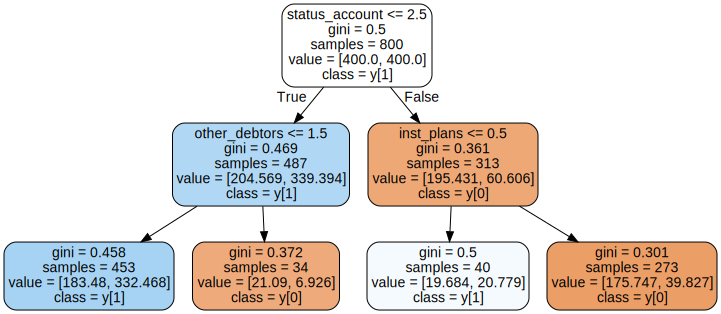

In [22]:
# 1.可视化输出
out_file = os.path.join(IMAGES_PATH, "Credit_tree.dot")
export_graphviz(
        tree_model,
        out_file=out_file, # 输出决策树文档，为制图做准备
        feature_names=feat_selector.feats,
        # class_names=['good','bad'],
        class_names=True,
        rounded=True,
        filled=True
    )
Source.from_file(out_file)

In [29]:
base_data['status_account'].value_counts()

3.0    394
0.0    274
1.0    269
2.0     63
Name: status_account, dtype: int64

In [23]:
# 2.转为python代码输出
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    print("def predict({}):".format(", ".join(feature_names)))
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature]
    
    def recurse(node, depth):
        """前序遍历树节点"""
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED: # 非叶节点
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_right[node], depth + 1)
        else: # 叶节点
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

tree_to_code(tree_model, feat_selector.feats)

def predict(age, amount, credit_history, duration, housing, income_rate, inst_plans, other_debtors, personal_status, present_emp, property, purpose, status_account, svaing_account):
  if status_account <= 2.5:
    if other_debtors <= 1.5:
      return [[183.4797891  332.46753247]]
    else:  # if other_debtors > 1.5
      return [[21.08963093  6.92640693]]
  else:  # if status_account > 2.5
    if inst_plans <= 0.5:
      return [[19.68365554 20.77922078]]
    else:  # if inst_plans > 0.5
      return [[175.74692443  39.82683983]]
